# Construction and validation of bioNLP named entity recognition model using deep learning
Problems: the embeddings I trained is worse than the one from google

deep_nlp_serial

Attribution: 
    Some of the code are borrowed from the example code from spacy

In [1]:
import tensorflow
from tqdm import tqdm

import keras
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pathlib
import cytoolz
import numpy
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import TimeDistributed
from keras.optimizers import Adam
import thinc.extra.datasets
from spacy.compat import pickle
import spacy
import pandas as pd
from sklearn import preprocessing
import keras
from sklearn import model_selection
#import seaborn as sns
from sklearn import metrics
#import matplotlib.pyplot as plt

Using TensorFlow backend.
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


### load in SRA data

Wall time: 47.5 s


In [2]:
%%time 
inS_dir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'
sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'
srsS=pd.read_pickle(inS_dir)
technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)


CPU times: user 8.98 s, sys: 3.4 s, total: 12.4 s
Wall time: 12.4 s


In [3]:
technical_meta_data_df=technical_meta_data_df.sample(technical_meta_data_df.shape[0])

### load in spacy models

Wall time: 52.1 s


In [4]:
%%time
#nlp=spacy.load('en_vectors_web_lg')
#wikipedia-pubmed-and-PMC-w2v
nlp=spacy.load('./wikipedia-pubmed-and-PMC-w2v')

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


CPU times: user 1min 14s, sys: 7.54 s, total: 1min 22s
Wall time: 1min 22s


### Functions for model compilation and feature extraction

Useful information for understanding the neural network: 

TimeDistributed: https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

lr stands for: learning rate

In [5]:
def compile_lstm(embeddings, shape, settings):
    model = Sequential()
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape['max_length'],
            trainable=False,
            weights=[embeddings],
            mask_zero=True
        )
    )
    #the same dense layer is first applied extract the most useful info from embedding layers
    model.add(TimeDistributed(Dense(shape['nr_hidden'], use_bias=False)))
    model.add(Bidirectional(LSTM(shape['nr_hidden'],
                                 recurrent_dropout=settings['dropout'],
                                 dropout=settings['dropout'])))
    model.add(Dense(shape['nr_class'], activation='sigmoid'))
    model.compile(optimizer=Adam(lr=settings['lr']), loss='categorical_crossentropy',
		  metrics=['accuracy'])
    return model

def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in tqdm(enumerate(docs),total=len(docs)):
        j = 0
        for token in doc:
            ##rever to word vector
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

# subset sra data 

In [6]:
srsWithText=srsS.index.get_level_values(0).unique()

In [7]:
technical_meta_data_df_sub=technical_meta_data_df[technical_meta_data_df.Sample.isin(srsWithText)]

### subset data based on entity types grouped by word vectors

In [8]:
grouping_df=pd.read_csv('./Results/grouping.csv')

In [9]:
##attributes, original attributes from NCBI
grouping_df.head(n=15)

,Unnamed: 0,GroupName,I,Attributes,cosine,VC
0,0,Species,0,SCIENTIFIC_NAME,1.000000,1136856
1,1,Species,1,organism,0.983355,29037
2,2,Species,2,Organism,0.897151,2894
3,3,Species,3,host scientific name,0.863731,9909
4,4,Species,4,Species,0.851593,578
5,5,Species,5,host,0.837771,205511
6,6,Species,6,specific host,0.830889,11114
7,7,Species,7,host_scientific_name,0.826836,4297
8,8,Species,8,host organism,0.825852,372
9,9,Species,9,nat-host,0.819286,1516


### cap contribution by each study

In [10]:
max_sample_per_study_n=100

In [11]:
myAttribs=grouping_df.Attributes.unique()

In [12]:
subsampledSrs=technical_meta_data_df.groupby('Study').head(n=max_sample_per_study_n)['Sample']
print ('classify: {}'.format(", ".join(myAttribs)))
m=srsS.index.get_level_values(0).isin(subsampledSrs.values)
m1=srsS.index.get_level_values(1).isin(myAttribs)
srsS_subS=srsS[m&m1]

classify: SCIENTIFIC_NAME, organism, Organism, host scientific name, Species, host, specific host, host_scientific_name, host organism, nat-host, specific_host, genotype, genotype/variation, plant genotype, mutant, mutation, phenotype, host_genotype, disease, tumor type, diagnosis, disease state, DiseaseState, cancer type, tumor, clinical history, disease status, cell description, cell type, cell_type, source cell type, cell types, source_name, cell-type, CellType, cell subtype, biomaterial_type, progenitor cell type, tissue/cell type, DIFFERENTIATION_STAGE, cell, differentiation status, cell line source, geo_loc_name, geographic location, geo loc name, geographic location (country and/or sea, region), geographic location (country and/or sea,region), country, "geographic location (country and/or sea,region)", birth_location, geographic location (country and/or sea), Geo_loc_name, treatment, treated with, treatment protocol, drug treatment, agent, stimulated with, protocol, Treatment, s

In [13]:
srsS_subS.head()

SRS1024493  SCIENTIFIC_NAME                  Camellia oleifera
            geo_loc_name       China: 856 m, Jinggang Mountain
SRS568274   SCIENTIFIC_NAME    Escherichia coli 2-316-03_S3_C1
            country                                   Tanzania
            nat-host                              Homo sapiens
dtype: object

###  

### filter text with missing or unknowns

In [14]:
filterTextL=['not collected','not applicable','missing','n[/]?a','unknown']
filterTextRegex="|".join(map(lambda myStr:'(?:{})'.format(myStr),filterTextL))

In [15]:
srs_filterM=srsS_subS.str.contains(filterTextRegex,case=False)
srsS_subS=srsS_subS[~srs_filterM].str.replace( '\s+',' ')

In [16]:
word_countS=srsS_subS.str.count(' ' )+1

In [17]:
#np.log2(word_countS+1).value_counts()

In [18]:
wordCount_m=(word_countS>=2)&(word_countS<=7)
myDf=srsS_subS[wordCount_m].reset_index()
myDf.columns=['srs','attrib','sentence']

remove _ which is often used for spacing as opposed to space

In [19]:
myDf['sentence']=myDf['sentence'].str.replace('_',' ')

# split data into training and  testing randomly by study levels

It is split by study level to avoid overgeneralization

In [20]:
train_test_ratio=0.8

In [21]:
study_S=technical_meta_data_df_sub['Study'].drop_duplicates()
print (len(study_S))
myNStudies=len(study_S)
train_n=int((myNStudies*train_test_ratio))
train_studies=study_S.sample(n=train_n,random_state=0).values
technical_meta_data_df_sub['Train']=technical_meta_data_df_sub['Study'].isin(train_studies).values

106722


/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


slice out the training and testing SRS ids

In [22]:
train_mask=technical_meta_data_df_sub['Train']
train_samples=technical_meta_data_df_sub['Sample'][train_mask].values
test_samples=technical_meta_data_df_sub['Sample'][~train_mask].values

### rename the attrib based on the grouped class name

In [23]:
myDf['orig_attrib']=myDf['attrib']
AttribToGroupNameS=grouping_df.groupby('Attributes')['GroupName'].first()
myDf['attrib']=AttribToGroupNameS[myDf['orig_attrib'].values].values

In [24]:
### set training and testing within the dataframe
all_train_df=myDf[myDf.srs.isin(train_samples)]
g=all_train_df.groupby('attrib')
print (g.size())

attrib
Cell type/tissue            214664
Disease state                12603
Genotype                     44394
Geographical Location       152611
Species                     971214
Treatment and conditions     27500
dtype: int64


In [25]:
#g

### filter based on data availability

### cap on text duplicates

In [26]:
nDupTextMax=1000

In [27]:
all_train_df=all_train_df.sample(all_train_df.shape[0])

In [28]:
#dedup_train_df=all_train_df.groupby(['orig_attrib','sentence']).head(n=nDupTextMax)
categorical_fields=['SCIENTIFIC_NAME']
dedup_train_df=all_train_df[~all_train_df.orig_attrib.isin(['SCIENTIFIC_NAME'])
                           ].groupby(['sentence']).head(n=nDupTextMax)

### subsetting training and testing data 
shuffle the training data to make sure the model isn't learning the ordering of the data

In [29]:
cap_size=20000#20000#1000#50000
train_df=dedup_train_df.sample(dedup_train_df.shape[0]).groupby('attrib').head(n=cap_size)
all_test_df=myDf[myDf.srs.isin(test_samples)]
test_df=all_test_df.sample(n=all_test_df.shape[0]).groupby('attrib').head(cap_size)

In [30]:
#train_df

In [31]:
#dedup_train_df.attrib.value_counts()

In [32]:
#dedup_train_df[dedup_train_df.attrib=='SCIENTIFIC_NAME']['sentence'].value_counts()

### set up LSTM model

In [33]:
nr_hidden=64 
max_length=7#, #95% percentile of training phrase length from NCIT
dropout=0.5
learn_rate=0.001#, # General NN config
nb_epoch=1#
batch_size=100

use the sklearn encoder going back and forth between classes in string format and integer format

In [34]:
classNames=AttribToGroupNameS.unique()

In [35]:
le = preprocessing.LabelEncoder()
le.fit(classNames)
nr_classes=len(le.classes_)

In [36]:
lstm_shape={'nr_hidden': 64, 'max_length': max_length, 'nr_class': nr_classes}
lstm_settings={'dropout': 0.5, 'lr': 0.001}

In [37]:
embeddings = nlp.vocab.vectors.data

### transform list of freetexts into a matrix of word embeddings

In [38]:
train_df.attrib.value_counts()

Geographical Location       20000
Treatment and conditions    20000
Species                     20000
Cell type/tissue            20000
Genotype                    20000
Disease state               12598
Name: attrib, dtype: int64

In [39]:
test_df.attrib.value_counts()

Species                     20000
Geographical Location       20000
Cell type/tissue            20000
Genotype                    11162
Treatment and conditions     7161
Disease state                2713
Name: attrib, dtype: int64

In [40]:
train_texts=train_df.sentence.tolist()
dev_texts=test_df.sentence.tolist()

train_labels=keras.utils.to_categorical(
    le.transform(train_df.attrib.values))
dev_labels=keras.utils.to_categorical(le.transform(test_df.attrib.values))

train_docs = list(tqdm(nlp.pipe(train_texts,n_threads=32),total=len(train_texts)))
dev_docs = list(tqdm(nlp.pipe(dev_texts,n_threads=32),total=len(dev_texts)))

train_X = get_features(train_docs, lstm_shape['max_length'])
dev_X = get_features(dev_docs, lstm_shape['max_length'])

100%|██████████| 81036/81036 [00:01<00:00, 66118.65it/s]


#### Model training


#26 mins per epoch, on a machine with 48 threads, might want to use GPU machine bordeaux for this 


In [41]:
#!rm ./model/lstm.h5

In [42]:
#model_path='./model/lstm.h5'
#log_dir="logs/"

In [43]:
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint
from IPython.utils import io

#checkpoint = ModelCheckpoint(monitor='val_acc', verbose=1, mode='max')
#tf_callBack=keras.callbacks.TensorBoard(log_dir=log_dir)
#call_backs = [tf_callBack,checkpoint]

In [44]:
numpy.save('./model/classes.npy', le.classes_)

In [45]:
model = compile_lstm(embeddings, lstm_shape, lstm_settings)

In [46]:
%%capture keras_stdout
lstm=model.fit(train_X, train_labels, validation_data=(dev_X, dev_labels),
          nb_epoch=nb_epoch,verbose=1, batch_size=batch_size)

In [47]:
lstm.model.save('./model/lstm.h5')

In [48]:
#!rm ./model/lstm.h5

In [49]:
#asdasdas

In [50]:
#0.93458
#print (keras_stdout)
#ValueError: Error when checking target: expected dense_4 to have shape (46,) but got array with shape (41,)


In [51]:
#%%capture MyTest
#print ("asdasd")


### see how training accuracy improve as the amount of data increase

In [52]:
keras_stdout_str=keras_stdout.stdout

In [53]:
trainingAcc=pd.Series(keras_stdout_str.split('\r')).str.replace('\x08','').str.extract('acc: (\d+.\d+)').dropna()[0].astype(float)

In [54]:
trainingAcc.index=trainingAcc.index*batch_size/1000

In [55]:
#trainingAcc

In [56]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [57]:
np.arange(0,0.9,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

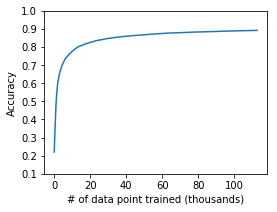

In [58]:
fig,ax=plt.subplots(figsize=(4,3))
trainingAcc.plot(ax=ax)
#ax.set_ylabel('#')
ax.set_xlabel('# of data point trained (thousands)')
ax.set_ylabel('Accuracy')
ax.set_yticks(np.arange(0.1,1.1,0.1))
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.figure.savefig('./Results/Figures/data_vol__accuracy.pdf')
ax.figure.savefig('./Results/Figures/data_vol__accuracy.png',dpi=300)

### evaluate model

In [59]:
from keras.models import load_model


In [60]:
#lstm=load_model('./model/lstm.h5')

In [61]:
val_docs = list(tqdm(nlp.pipe(dev_texts,),total=len(dev_texts)))
val_X=get_features(val_docs,lstm_shape['max_length'])
%time predictM=lstm.model.predict_proba(val_X)

100%|██████████| 81036/81036 [00:01<00:00, 70126.53it/s]


CPU times: user 6min, sys: 9.42 s, total: 6min 9s
Wall time: 14.9 s


In [62]:
probaDf_multI=pd.DataFrame(data=predictM,columns=le.classes_)

In [63]:
probaDf_multI.index=pd.MultiIndex.from_arrays([test_df.attrib.values,dev_texts],names=['entity','text'])

In [64]:
probaDf=probaDf_multI.reset_index()

In [65]:
predicted_types=probaDf.loc[:,probaDf.columns.isin(myAttribs)].idxmax(axis=1)


In [66]:
print ('Accuracy:',((probaDf.entity==predicted_types).mean()))

0.24680388962930055


In [67]:
#probaDf

### show contingency tables

In [68]:
#filterTextL=['not collected','not applicable','missing','n[/]?a']

#filterTextRegex="|".join(map(lambda myStr:'(?:{})'.format(myStr),filterTextL))

In [69]:
#m_cleanText=~probaDf_multI.index.get_level_values('text').str.contains(filterTextRegex,case=False)

In [70]:
#probaDf

In [71]:
inEvalDf=probaDf_multI#.loc[~probaDf_multI.index.get_level_values('entity').isin(['strain']),~probaDf_multI.columns.isin(['strain'])]#[m_cleanText]

In [72]:
#inEvalDf

In [73]:
minProbThreshold=0.2
confidence_mask=inEvalDf.max(axis=1)>=minProbThreshold
tmpDf3=inEvalDf.idxmax(axis=1).reset_index(name='predicted')

In [74]:
tmpDf3.groupby('predicted').size()

predicted
Cell type/tissue            18593
Disease state                3703
Genotype                    11381
Geographical Location       19743
Species                     19834
Treatment and conditions     7782
dtype: int64

In [75]:
continDf=tmpDf3.groupby(['predicted','entity']).size().unstack().fillna(0)

In [76]:
continDf.columns=continDf.columns.copy()

In [77]:
attribVC_train=train_df.attrib.value_counts()#.to_frame()

### plot heatmap

In [78]:
#fig,ax=plt.subplots(figsize=(5,5))#3,2
#,cmap="Greens"
continDf=continDf.loc[attribVC_train.index,attribVC_train.index]
continDf.index=continDf.index.copy()
continDf.columns=continDf.columns.copy()
continDf.index.name='Predicted'
continDf.columns.name='Actual'
percentDf=(continDf/continDf.sum(axis=0)).T*100

In [79]:
g=sns.clustermap(data=percentDf,annot=True,cbar_kws={'label':'% of samples'},center=0.1,
           fmt='.1f')
plt.close()

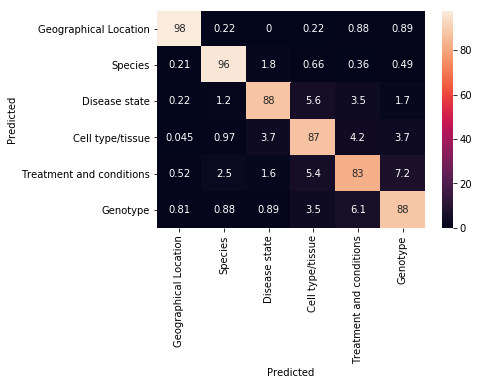

In [80]:
sns.heatmap(data=percentDf.loc[g.data2d.columns,g.data2d.columns],annot=True)

In [81]:
contdf_long=percentDf.stack().reset_index(name='Percent')

In [82]:
contdf_wrong=contdf_long[contdf_long.Actual!=contdf_long.Predicted].sort_values('Percent')
contdf_wrong[contdf_wrong.Percent>5]

,Actual,Predicted,Percent
9,Treatment and conditions,Cell type/tissue,5.404273
33,Disease state,Cell type/tissue,5.602654
25,Genotype,Treatment and conditions,6.065221
10,Treatment and conditions,Genotype,7.205698


{'Cell type/tissue': 0.18428203463554382,
 'Disease state': 0.3279467225074768,
 'Genotype': 0.33396194875240326,
 'Geographical Location': 0.8687592148780823,
 'Species': 0.4428570568561554,
 'Treatment and conditions': 0.09008346498012543}

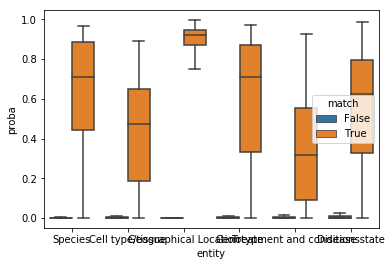

In [83]:
predDf=probaDf_multI.stack().reset_index()

predDf.columns=['entity','text','predicted','proba']

predDf['match']=predDf.entity==predDf.predicted

sns.boxplot(data=predDf,x='entity',y='proba',hue='match',showfliers=False)

#predDf[~predDf['match']].groupby(['entity'])['proba'].quantile(0.95).to_dict()

predDf[predDf['match']].groupby(['entity'])['proba'].quantile(0.25).to_dict()

#### Performance of model in validation cohort

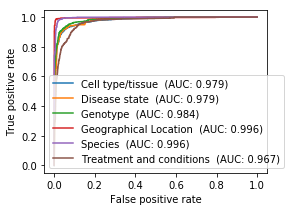

In [84]:
fig,ax=plt.subplots(figsize=(4,3
                            ))
for myClass in le.classes_: 
    fpr,tpr,_=metrics.roc_curve((probaDf.entity==myClass),probaDf[myClass])    
    ax.plot(fpr,tpr,label="{myClass}  (AUC: {AUC})".format(myClass=myClass,AUC=str(metrics.auc(fpr,tpr))[:5]))
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend()

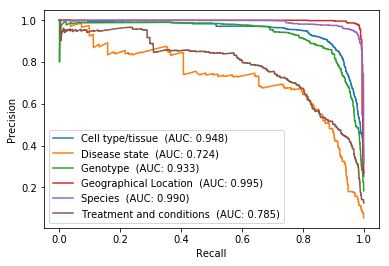

In [85]:
fig,ax=plt.subplots()
for myClass in le.classes_: 
    precision,recall,_=metrics.precision_recall_curve((probaDf.entity==myClass),probaDf[myClass])    
    ax.plot(recall, precision,label="{myClass}  (AUC: {AUC})".format(myClass=myClass,AUC=str(metrics.auc(recall,precision))[:5]))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

In [86]:
#probaDf

In [87]:
#for myClass in le.classes_: 
#    print (myClass,metrics.f1_score((probaDf.entity==myClass),probaDf[myClass]))


### entities

In [88]:
#inEvalDf

In [89]:
entity_a=inEvalDf.index.get_level_values('entity')

In [90]:
inTmpDf=inEvalDf.idxmax(axis=1).reset_index(name='predicted')

In [91]:
inTmpDf['correct']=inTmpDf.entity==inTmpDf.predicted

In [92]:
inTmpDf.to_csv('./model/pred.csv')

In [93]:
#Breed, SCIENTIFIC_NAME
inTmpDf.entity.value_counts()

Species                     20000
Geographical Location       20000
Cell type/tissue            20000
Genotype                    11162
Treatment and conditions     7161
Disease state                2713
Name: entity, dtype: int64

In [94]:
inTmpDf[(inTmpDf.predicted=='breed')&(inTmpDf.entity=='breed')]

,entity,text,predicted,correct


In [95]:
inTmpDf['correct'].mean()

0.9187768399229972

In [96]:
inTmpDf.groupby('entity')['correct'].mean().sort_values()

entity
Treatment and conditions    0.827678
Cell type/tissue            0.874400
Disease state               0.878363
Genotype                    0.878785
Species                     0.964400
Geographical Location       0.977950
Name: correct, dtype: float64

In [97]:
## use synapse for downloading

In [98]:
#inEvalDf[entity_a=='breed'].sort_values('breed',ascending=False).index.get_level_values('text').value_counts()

In [99]:
inEvalDf.head()

Cell type/tissue  \
entity                text                                                                 
Species               Mus musculus                                              0.000092   
                      Mus musculus                                              0.000092   
Cell type/tissue      human K562 cells and mouse embryonic fibroblasts          0.554250   
                      Cranial neural crest cells                                0.736662   
Geographical Location USA: Lake Washington, Seattle, Washington                 0.000042   

                                                                        Disease state  \
entity                text                                                              
Species               Mus musculus                                           0.000005   
                      Mus musculus                                           0.000005   
Cell type/tissue      human K562 cells and mouse embryonic fibroblasts       0.008547   
                      Cranial neural crest cells                             0.010084   
Geographical Location USA: Lake Washington, Seattle, Washington              0.000022   

                                                                        Genotype  \
entity                text                                                         
Species               Mus musculus                                      0.000139   
                      Mus musculus                                      0.000139   
Cell type/tissue      human K562 cells and mouse embryonic fibroblasts  0.000727   
                      Cranial neural crest cells                        0.001842   
Geographical Location USA: Lake Washington, Seattle, Washington         0.000238   

                                                                        Geographical Location  \
entity                text                                                                      
Species               Mus musculus                                                   0.000012   
                      Mus musculus                                                   0.000012   
Cell type/tissue      human K562 cells and mouse embryonic fibroblasts               0.000002   
                      Cranial neural crest cells                                     0.000003   
Geographical Location USA: Lake Washington, Seattle, Washington                      0.923999   

                                                                         Species  \
entity                text                                                         
Species               Mus musculus                                      0.711758   
                      Mus musculus                                      0.711758   
Cell type/tissue      human K562 cells and mouse embryonic fibroblasts  0.003510   
                      Cranial neural crest cells                        0.000641   
Geographical Location USA: Lake Washington, Seattle, Washington         0.000047   

                                                                        Treatment and conditions  
entity                text                                                                        
Species               Mus musculus                                                      0.000103  
                      Mus musculus                                                      0.000103  
Cell type/tissue      human K562 cells and mouse embryonic fibroblasts                  0.001720  
                      Cranial neural crest cells                                        0.001557  
Geographical Location USA: Lake Washington, Seattle, Washington                         0.000124

### calculated F1 score

In [100]:
"""
``'binary'``:
        Only report results for the class specified by ``pos_label``.
        This is applicable only if targets (``y_{true,pred}``) are binary.
    ``'micro'``:
        Calculate metrics globally by counting the total true positives,
        false negatives and false positives.
    ``'macro'``:
        Calculate metrics for each label, and find their unweighted
        mean.  This does not take label imbalance into account.
    ``'weighted'``:
        Calculate metrics for each label, and find their average, weighted
        by support (the number of true instances for each label). This
        alters 'macro' to account for label imbalance; it can result in an
        F-score that is not between precision and recall.
    ``'samples'``:
        Calculate metrics for each instance, and find their average (only
        meaningful for multilabel classification where this differs from
        :func:`accuracy_score`).
"""
print( metrics.f1_score(y_true=inTmpDf['entity'],y_pred=inTmpDf['predicted'],average='weighted'))

0.9204442196478915


# scratch

In [101]:
asdadasd

NameError: name 'asdadasd' is not defined

### for a sentence split

In [ ]:
import nltk
from nltk.util import ngrams
#"tp53 knock out in T cell", "53 year old knock down"
sent="melanoma patients has BRAF mutations"
sent="melanoma cells has BRAF mutations"
sent="5 year old "

sent="5 human melanocytes with knockout"

#sent='subject 134982 is a cute female'
s=sent.split(' ')
n_gram=2
grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
print (grams)
val_docs = list(nlp.pipe(grams))
val_X=get_features(val_docs,lstm_shape['max_length'])
tmpDf=pd.DataFrame(data=model.predict_proba(val_X),columns=le.classes_,index=grams)
tmpDf[(tmpDf>0.1).sum(axis=1)!=1]=0
ax=sns.heatmap(tmpDf,cbar_kws={'label': 'Emitted probability'},annot=True)
ax.set_ylabel('')
ax.set_title('{} grams'.format(n_gram))

In [ ]:
#

In [ ]:
val_X=get_features(val_docs,lstm_shape['max_length'])

In [ ]:
!echo $PWD/Data/DEEP_NLP/NLP_spacy/keras_on_sra_data_v2.ipynb

In [ ]:


tmpS3=srsS[srsS.index.get_level_values(1)=='cur_land_use']

In [ ]:
len(tmpS3.value_counts())

In [ ]:
#no data: biomass,chem_mutagen
srsS.head()

In [ ]:
def most_similar(word):
    by_similarity = sorted(word.vocab, key=lambda w: word.similarity(w), reverse=True)
    return [w.orth_ for w in by_similarity[:10]]

In [ ]:
#most_similar(nlp.vocab['missing'])

In [ ]:
train_df['sentence'][train_df['attrib']=='sex'].value_counts()

In [ ]:
'knockdown' in nlp.vocab

In [ ]:
train_df[train_df['attrib']=='cell type'].sentence.str.count(' ').quantile(0.95)

### check for threshold

In [ ]:
predDf=probaDf_multI.stack().reset_index()

predDf.columns=['entity','text','predicted','proba']

predDf['match']=predDf.entity==predDf.predicted

sns.boxplot(data=predDf,x='entity',y='proba',hue='match',showfliers=False)

predDf[~predDf['match']].groupby(['entity'])['proba'].quantile(0.95).to_dict()

predDf[predDf['match']].groupby(['entity'])['proba'].median().to_dict()

In [ ]:
predDf.groupby('proba')

In [ ]:
all_train_df_sub=all_train_df[all_train_df.attrib=='SCIENTIFIC_NAME']

In [ ]:
senVC=all_train_df_sub.sentence.value_counts()

In [ ]:
#senVC[senVC.index.str.contains('mouse')]

In [ ]:
takeOnlyTopXTest=1000
srsTmpDf=srsS_subS.reset_index()
srsTmpDf.columns=['SRS','Attrib','Text']
balancedDf=srsTmpDf.groupby(['Attrib','Text']).head(n=takeOnlyTopXTest)

srsS_subS=balancedDf.set_index(['SRS','Attrib'])['Text']

In [ ]:
from nltk.corpus import stopwords


In [ ]:
stopwords.words('english')

In [ ]:
all_train_df[all_train_df.attrib=='SCIENTIFIC_NAME']['sentence'].value_counts()

In [ ]:
train_df[train_df.attrib=='SCIENTIFIC_NAME']['sentence'].value_counts()

In [ ]:
#'-/-' in nlp.vocab

In [ ]:
sub_trainDf=train_df[train_df.attrib=='sex']['sentence'].value_counts()

In [ ]:
sub_trainDf[sub_trainDf.index.str.contains('captured')]

In [ ]:
"""
a flat file with the annotations
For each content,
thre is an annotations, 
show the label, and the points, 

{"content":"cd players and tuners","annotation":[{"label":["Category"],"points":[{"start":0,"end":1,"text":"cd"}]},{"label":["Category"],"points":[{"start":3,"end":9,"text":"players"}]},{"label":["Category"],"points":[{"start":15,"end":20,"text":"tuners"}]}],"extras":{"Name":"columnName","Class":"ColumnValue"}}

"""

In [ ]:
sentenceVC=all_train_df[all_train_df.attrib.str.contains('genotype')]['sentence'].value_counts()

In [ ]:
sentenceVC[sentenceVC.index.str.contains('diffuse')]